# EM dataset

This notebook plots the overviews for the EM dataset in figure 4

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path
import numpy as np

from lotr import DATASET_LOCATION
from lotr import plotting as pltltr
from lotr.analysis.pool_cell_info import get_pooled_cell_info
from lotr.em.core import MIDLINES
from lotr.em.loading import load_skeletons_from_zip
from lotr.utils import linear_regression
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.ndimage.morphology import binary_dilation
from tqdm import tqdm

COLS = pltltr.COLS

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_37399/3115252464.py:12: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


## Data loading

In [3]:
# Reference:
# Load the gad1b stack and the annotation from the IPN atlas:

from bg_atlasapi.core import Atlas

atlas = Atlas(DATASET_LOCATION.parent / "anatomy" / "ipn_zfish_0.5um_v1.8")

gad1b_stack = atlas.additional_references["gal4_gad1b"]
gad1b_stack[gad1b_stack > 2**16-1000] = 0  # ugly fix for histogram normalization issue


# Enlarge a bit the mask for the IPN (in the future we'll draw better masks):
mask = np.zeros((3, 3, 3)).astype(bool)
mask[:, 1, :] = True
annotation = atlas.get_structure_mask("ipn") > 0  # binary_dilation(, iterations=7, structure=mask )
annotation_dipn = atlas.get_structure_mask("dipn") > 0  # binary_dilation(, iterations=7, structure=mask)

/Users/vigji/miniforge3/envs/rplab/lib/python3.8/site-packages/bg_atlasapi/core.py:338: UserWarning: No reference named gad1b_gal4 (available: ['16715', 'gad1b', 'h2b', 'gal4_gad1b'])
  warnings.warn(


In [25]:
# Load the EM and mirror neurons on one side:
em_path = DATASET_LOCATION.parent / "anatomy" / "aHB_dIPN.k.zip"

sel_neurons = load_skeletons_from_zip(em_path)

sel_neurons_not_mirr = sel_neurons.copy()
for n in sel_neurons:
    n.mirror_right = True

In [7]:
#  Specify axes limits over all dimensions:
bs = dict(frontal=(30, 180), vertical=(-4, 170), sagittal=(-50, 120))

plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

## All projections with anatomy

Load positions of all r1pi neurons in the IPN standard reference

In [11]:
cells_df = get_pooled_cell_info()

coords_not_mirr = cells_df.loc[cells_df["hdn"], [f"centered{i}" for i in range(3)]].values
coords_not_mirr[:, 1] += np.random.rand(coords_not_mirr.shape[0]) * 10

coords = coords_not_mirr.copy()
# Mirror on the right side
left = coords[:, 2] < MIDLINES["ipn"]
coords[left, 2] = MIDLINES["ipn"] + (MIDLINES["ipn"] - coords[left, 2])
idx_coords = (coords * 2).astype(int)

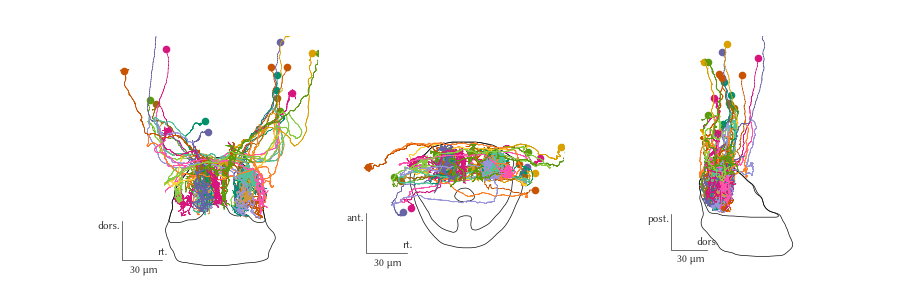

In [22]:
f, axs = plotter.generate_projection_plots()
for n in sel_neurons:
    n.mirror_right = True
    
lw = 0.5
for i, neuron in enumerate(sel_neurons):
    main_c = COLS["qualitative"][i % len(COLS["qualitative"])]
    plotter.plot_neurons(
        axs,
        neuron,
        select="dendrites",
        c=pltltr.shift_lum(main_c, -0.05),
        lw=lw,
        soma_s=30,
    )
    plotter.plot_neurons(
        axs,
        neuron,
        select="axon",
        c=pltltr.shift_lum(main_c, 0.15),
        lw=lw,
        soma_s=0,
        rasterized=True,
    )

for i, (proj, pos) in enumerate(
    zip(plotter.space.sections, [(35, 165), (35, 110), (5, 165)])
):
    pltltr.add_anatomy_scalebar(
        axs[i], plane=proj, pos=pos, cartesian=True, equalize_axis=False, length=30,
    )
#pltltr.savefig("dipn_neurons_noanat", folder="S10")

In [23]:
import matplotlib.cm as cm

cmap = cm.get_cmap("GnBu").copy()
cmap.set_under("none")
# cmap.set_over("none")

t = [False, False, True]


gad1b_slices = [slice(20, 170), slice(None), slice(None)]
plotter.axs_scatterplot(axs, coords, c=COLS["qualitative"][0], alpha=0.08, s=10, lw=0, rasterized=True)
for i in range(3):
    slices = [slice(None, None),] * 3
    slices[i] = gad1b_slices[i]
    im = gad1b_stack[slices].max(i)
    im_dens = filt_dens.max(i)
    if t[i]:
        im = im.T
        im_dens = im_dens.T
    axs[i].imshow(
        im,
        origin="lower",
        cmap="gray_r",
        vmin=450,
        vmax=10000,
        extent=(0, gad1b_stack.shape[2] / 2, 0, gad1b_stack.shape[1] / 2),
    )
    """
    im_dens_mask = im_dens / np.percentile(im_dens, 99.9)
    im_dens_mask[im_dens_mask > 1] = 1
    im_dens_mask *= 0.9
    axs[i].imshow(
        im_dens,
        cmap=cmap,
        alpha=im_dens_mask,
        extent=(0, gad1b_stack.shape[2] / 2, 0, gad1b_stack.shape[1] / 2),
        vmin=0.00035,
        vmax=0.009,
    )"""
pltltr.savefig("dipn_neurons_anat")

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_37399/226042713.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im = gad1b_stack[slices].max(i)


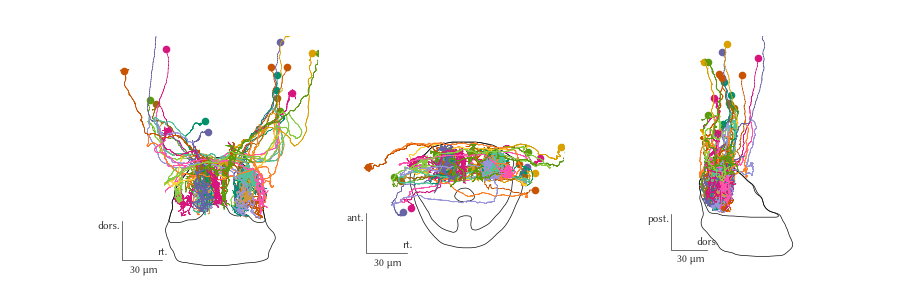

In [26]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, neuron in enumerate(sel_neurons_not_mirr):
    main_c = COLS["qualitative"][i % len(COLS["qualitative"])]
    plotter.plot_neurons(
        axs,
        neuron,
        select="dendrites",
        c=pltltr.shift_lum(main_c, -0.05),
        lw=lw,
        soma_s=30,
        rasterized=True
    )
    plotter.plot_neurons(
        axs,
        neuron,
        select="axon",
        c=pltltr.shift_lum(main_c, 0.15),
        lw=lw,
        soma_s=0,
        rasterized=True,
    )

for i, (proj, pos) in enumerate(
    zip(plotter.space.sections, [(35, 165), (35, 110), (5, 165)])
):
    pltltr.add_anatomy_scalebar(
        axs[i], plane=proj, pos=pos, cartesian=True, equalize_axis=False, length=30,
    )
pltltr.savefig("dipn_neurons_onlyem", folder="S11")

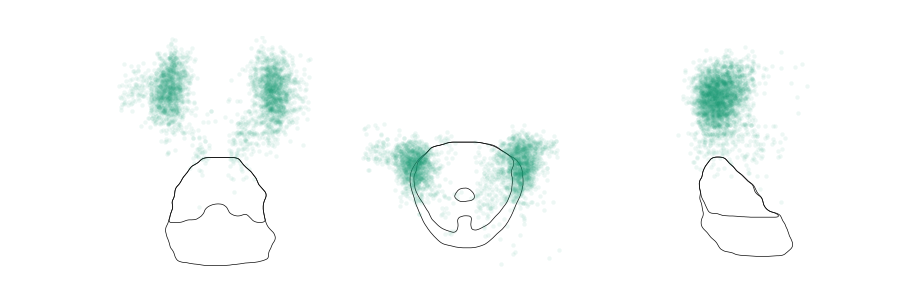

In [27]:
f, axs = plotter.generate_projection_plots()
plotter.axs_scatterplot(axs, coords_not_mirr, c=COLS["qualitative"][0], alpha=0.08, s=10, lw=0, rasterized=True)
pltltr.savefig("dipn_neurons_onlyring", folder="S11")

65536

In [58]:
im.max()

65436

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_37399/4208842665.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im = gad1b_stack[slices].max(i)


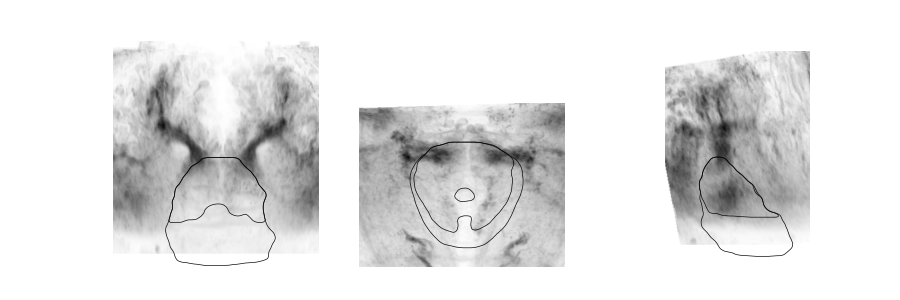

In [60]:
f, axs = plotter.generate_projection_plots()
t = [False, False, True]
gad1b_slices = [slice(20, 170), slice(None), slice(None)]
for i in range(3):
    slices = [slice(None, None),] * 3
    slices[i] = gad1b_slices[i]
    im = gad1b_stack[slices].max(i)
    im_dens = filt_dens.max(i)
    if t[i]:
        im = im.T
        im_dens = im_dens.T
    axs[i].imshow(
        im,
        origin="lower",
        cmap="gray_r",
        vmin=0,
        vmax=10000,
        extent=(0, gad1b_stack.shape[2] / 2, 0, gad1b_stack.shape[1] / 2),
    )
pltltr.savefig("dipn_neurons_onlyanat", folder="S11")

## Single projection with anatomy

In [ ]:
def plot_bg(ax):
    ax.imshow(
    gad1b_stack[20:170, :, :].max(0),
    origin="lower",
    cmap="gray_r",
    vmin=450,
    vmax=15000,
    extent=(0, (gad1b_stack.shape[2] / 2) * s, 0, (gad1b_stack.shape[1] / 2) * s),
    )
    pltltr.plot_projection(
        annotation[:120, :, :],
        0,
        ax=ax,
        smooth_wnd=15,
        linewidth=0.5,
        fill=False,
        edgecolor=".3",
    )
    pltltr.plot_projection(
        annotation_dipn[:120, :, :],
        0,
        ax=ax,
        smooth_wnd=15,
        linewidth=0.5,
        fill=False,
        edgecolor=".3",
    )

In [ ]:
off_x = 0
off_y = 0
s = 1.0
f, axs = plt.subplots(4, 5, figsize=(8, 8))

for i, neuron in enumerate(sel_neurons_not_mirr):
    ax = axs.flatten()[i]
    plot_bg(ax)
    main_c = COLS["qualitative"][i % len(COLS["qualitative"])]
    lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="dendrites")
    (l,) = ax.plot(
        lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, -0.15)
    )

    lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="axon")
    (l,) = ax.plot(
        lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, 0.15)
    )

    soma = neuron.coords_ipn[neuron.soma_idx, :]
    ax.scatter(soma[2], soma[1], s=30, color=pltltr.shift_lum(main_c, -0.15))
    ax.axis("equal")
    ax.set_title(neuron.id, c=main_c, fontsize=7, pad=-0.1)
    ax.set(ylim=(170, -25), xlim=(20, 190))
    
[pltltr.despine(ax, "all") for ax in axs.flatten()]

pltltr.add_scalebar(
    ax, ylen=-40, xlen=40, ypos=170, xpos=40, xlabel="L. - R.", ylabel="inf. sup."
)
pltltr.savefig("dipn_neurons_individual_neurons", folder="S12")

In [ ]:
f, ax = plt.subplots(figsize=(3, 3))
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):
    # if i == 1 or i == 6:
    lines = neuron.generate_plotlines_from_skeleton(space="ipn")
    col = cm.get_cmap("Reds")(c)
    soma = neuron.coords_ipn[neuron.soma_idx, :]
    fake_im = ax.scatter([], [], c=[], cmap="Reds")
    # if soma[2] > inclusion:
    # soma = midline - (midline - soma)
    #     lines[:, 2] = m - (lines[:, 2] - m)
    l = plt.plot(lines[:, 2], -lines[:, 1], lw=0.5, c=col)
    plt.scatter(soma[2], -soma[1], lw=0, fc=col)
ax.axis("equal")
ax.set(xlabel=("left-right"), ylabel="ventral - dorsal")
pltltr.despine(ax, "all")
fake_im = ax.scatter([], [], c=[], cmap="Reds")
pltltr.add_cbar(
    fake_im, ax, inset_loc=(0.9, 0.6, 0.035, 0.2), ticks=[], label="Dendrite pos"
)

In [ ]:
cols = COLS["qualitative"]

off_x = 0
off_y = 0
s = 1.0
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(
    gad1b_stack[20:170, :, :].max(0),
    origin="lower",
    cmap="gray_r",
    vmin=450,
    vmax=15000,
    extent=(0, (gad1b_stack.shape[2] / 2) * s, 0, (gad1b_stack.shape[1] / 2) * s),
)
pltltr.plot_projection(
    annotation[:120, :, :],
    0,
    ax=ax,
    smooth_wnd=15,
    linewidth=0.5,
    fill=False,
    edgecolor=".3",
)
pltltr.plot_projection(
    annotation_dipn[:130, :, :],
    0,
    ax=ax,
    smooth_wnd=15,
    linewidth=0.5,
    fill=False,
    edgecolor=".3",
)

for i, neuron in enumerate(sel_neurons):
    if "bilat" in neuron.comments.split("_") and "dipn" in neuron.comments.split("_"):
        main_c = cols[i % len(cols)]
        lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="dendrites")
        (l,) = ax.plot(
            lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, -0.15)
        )

        lines = neuron.generate_plotlines_from_skeleton(space="ipn", select="axon")
        (l,) = ax.plot(
            lines[:, 2], lines[:, 1], lw=0.5, c=pltltr.shift_lum(main_c, 0.15)
        )

        soma = neuron.coords_ipn[neuron.soma_idx, :]
        ax.scatter(soma[2], soma[1], s=30, color=pltltr.shift_lum(main_c, -0.15))
        ax.axis("equal")
        ax.set(ylim=(170, -4), xlim=(50, 160))

pltltr.despine(ax, "all")
pltltr.add_scalebar(
    ax, ylen=-20, xlen=20, ypos=140, xpos=40, xlabel="R. - L.", ylabel="inf. sup."
)